# Initial exploratory data analysis

This notebook creates a few quick plots to inspect spectral data and labels (class balance, relationships, and data quality checks).

In [3]:
# Load spectra dataset and prepare basic summaries (with normalization)
import sys
from pathlib import Path
import importlib

# ensure repo root is on path (search for 'src' or '.git' up the tree)
cwd = Path.cwd()
repo_root = None
for p in [cwd] + list(cwd.parents):
    if (p / 'src').exists() or (p / '.git').exists():
        repo_root = p
        break
if repo_root is None:
    repo_root = cwd
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
print('Repo root:', repo_root)

# import loader and reload in case of edits
import src.preprocessing.loader as loader_mod
importlib.reload(loader_mod)

# prepare spectra-based ML arrays
data_root = repo_root / 'data' / 'raw' / 'Plastic Washing CMSE project CSV files' / 'ATR set 1_washed'
X, y, feature_names, target_names = loader_mod.prepare_ml_dataset_spectra(data_root)

import numpy as np
from sklearn.decomposition import PCA

# Keep original spectra for reference
X_orig = X.copy() if X.size else X

# Normalize spectra per-file (z-score): subtract mean and divide by std per row
if X.size:
    eps = 1e-8
    row_means = X.mean(axis=1, keepdims=True)
    row_stds = X.std(axis=1, keepdims=True)
    X = (X - row_means) / (row_stds + eps)

# derived per-file summaries for plotting (use normalized spectra)
spec_means = X.mean(axis=1) if X.size else np.array([])
spec_vars = X.var(axis=1) if X.size else np.array([])

# PCA for 2D relationship plot (reduce spectra to 2 components)
if X.shape[0] > 1 and X.shape[1] > 1:
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(X)
else:
    pcs = np.zeros((X.shape[0], 2))

# polymer label extraction (assumes first 4 columns of y are polymers in order HDPE,LDPE,LLDPE,PP)
polymer_names = ['HDPE','LDPE','LLDPE','PP']
polymer_counts = y[:, :4].sum(axis=0).astype(int) if y.size else np.array([0,0,0,0])

# data quality measures
nan_counts = np.isnan(X).any(axis=1).sum() if X.size else 0
zero_var_counts = (spec_vars == 0).sum() if X.size else 0

print('Loaded X shape:', X.shape)
print('Loaded y shape:', y.shape)
print('Spectra points per sample:', X.shape[1] if X.size else 0)
print('Number of files with NaNs in spectra:', int(nan_counts))
print('Number of files with zero-variance spectra:', int(zero_var_counts))


Repo root: c:\Users\Mikey\Documents\GitHub\cmse492_project
Loaded X shape: (122, 1868)
Loaded y shape: (122, 9)
Spectra points per sample: 1868
Number of files with NaNs in spectra: 0
Number of files with zero-variance spectra: 0


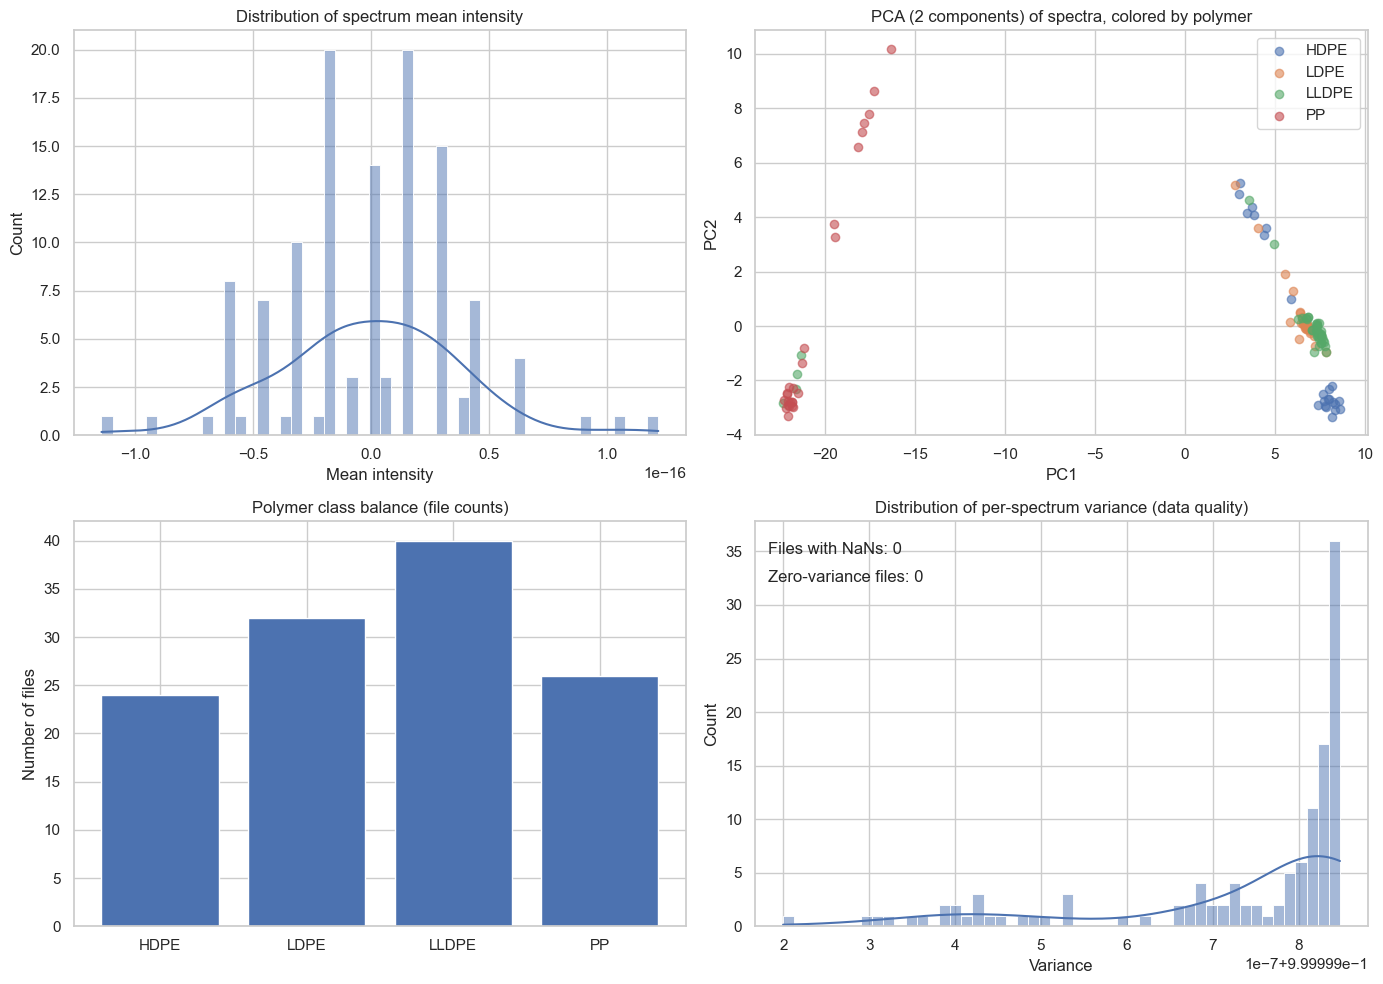

In [4]:
# Plotting: 4 panels (distribution, PCA relationship, class balance, data quality)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top-left: distribution of spectral mean intensity
ax = axes[0,0]
if spec_means.size:
    sns.histplot(spec_means, bins=50, kde=True, ax=ax)
    ax.set_title('Distribution of spectrum mean intensity')
    ax.set_xlabel('Mean intensity')
else:
    ax.text(0.5,0.5,'No data', ha='center')

# Top-right: PCA scatter colored by polymer
ax = axes[0,1]
if pcs.shape[0]:
    # get a discrete polymer label where possible
    poly_labels = np.argmax(y[:, :4], axis=1) if y.size else np.zeros(pcs.shape[0], dtype=int)
    palette = sns.color_palette('tab10', n_colors=4)
    for i, pname in enumerate(polymer_names):
        mask = poly_labels == i
        ax.scatter(pcs[mask,0], pcs[mask,1], label=pname, alpha=0.6)
    ax.set_title('PCA (2 components) of spectra, colored by polymer')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.legend()
else:
    ax.text(0.5,0.5,'No data', ha='center')

# Bottom-left: class balance for polymers
ax = axes[1,0]
labels = polymer_names
counts = polymer_counts
ax.bar(labels, counts)
ax.set_title('Polymer class balance (file counts)')
ax.set_ylabel('Number of files')

# Bottom-right: data quality - variance distribution and NaN/zero-variance annotations
ax = axes[1,1]
if spec_vars.size:
    sns.histplot(spec_vars, bins=50, kde=True, ax=ax)
    ax.set_title('Distribution of per-spectrum variance (data quality)')
    ax.set_xlabel('Variance')
    # annotate NaN/zero-variance counts
    ax.text(0.02, 0.95, f'Files with NaNs: {int(nan_counts)}', transform=ax.transAxes, va='top')
    ax.text(0.02, 0.88, f'Zero-variance files: {int(zero_var_counts)}', transform=ax.transAxes, va='top')
else:
    ax.text(0.5,0.5,'No data', ha='center')

plt.tight_layout()
plt.show()


In [5]:
# Save the 2x2 EDA figure to the figures folder
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ensure repo_root exists in this notebook (fallback to cwd)
try:
    fig_root = repo_root / 'figures'
except NameError:
    fig_root = Path.cwd() / 'figures'
fig_root.mkdir(parents=True, exist_ok=True)

sns.set(style='whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top-left: distribution of spectral mean intensity
ax = axes[0, 0]
if spec_means.size:
    sns.histplot(spec_means, bins=50, kde=True, ax=ax)
    ax.set_title('Distribution of spectrum mean intensity')
    ax.set_xlabel('Mean intensity')
else:
    ax.text(0.5, 0.5, 'No data', ha='center')

# Top-right: PCA scatter colored by polymer
ax = axes[0, 1]
if pcs.shape[0]:
    poly_labels = np.argmax(y[:, :4], axis=1) if y.size else np.zeros(pcs.shape[0], dtype=int)
    palette = sns.color_palette('tab10', n_colors=4)
    for i, pname in enumerate(polymer_names):
        mask = poly_labels == i
        ax.scatter(pcs[mask, 0], pcs[mask, 1], label=pname, alpha=0.6)
    ax.set_title('PCA (2 components) of spectra, colored by polymer')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.legend()
else:
    ax.text(0.5, 0.5, 'No data', ha='center')

# Bottom-left: class balance for polymers
ax = axes[1, 0]
labels = polymer_names
counts = polymer_counts
ax.bar(labels, counts)
ax.set_title('Polymer class balance (file counts)')
ax.set_ylabel('Number of files')

# Bottom-right: data quality - variance distribution and NaN/zero-variance annotations
ax = axes[1, 1]
if spec_vars.size:
    sns.histplot(spec_vars, bins=50, kde=True, ax=ax)
    ax.set_title('Distribution of per-spectrum variance (data quality)')
    ax.set_xlabel('Variance')
    ax.text(0.02, 0.95, f'Files with NaNs: {int(nan_counts)}', transform=ax.transAxes, va='top')
    ax.text(0.02, 0.88, f'Zero-variance files: {int(zero_var_counts)}', transform=ax.transAxes, va='top')
else:
    ax.text(0.5, 0.5, 'No data', ha='center')

plt.tight_layout()
out_path = fig_root / 'eda_normalized.png'
fig.savefig(out_path, dpi=200)
print(f'Saved EDA figure to: {out_path}')
plt.close(fig)


Saved EDA figure to: c:\Users\Mikey\Documents\GitHub\cmse492_project\figures\eda_normalized.png


In [6]:
# Save each EDA subplot individually to the figures folder
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# determine figures folder
try:
    fig_root = repo_root / 'figures'
except NameError:
    fig_root = Path.cwd() / 'figures'
fig_root.mkdir(parents=True, exist_ok=True)

sns.set(style='whitegrid')

# 1) Distribution of spectrum mean intensity
if spec_means.size:
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    sns.histplot(spec_means, bins=50, kde=True, ax=ax)
    ax.set_title('Distribution of spectrum mean intensity')
    ax.set_xlabel('Mean intensity')
    out1 = fig_root / 'dist_mean.png'
    fig.savefig(out1, dpi=200)
    plt.close(fig)
    print('Saved', out1)
else:
    print('No spec_means to save')

# 2) PCA scatter colored by polymer
if pcs.shape[0]:
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    poly_labels = np.argmax(y[:, :4], axis=1) if y.size else np.zeros(pcs.shape[0], dtype=int)
    palette = sns.color_palette('tab10', n_colors=4)
    for i, pname in enumerate(polymer_names):
        mask = poly_labels == i
        ax.scatter(pcs[mask,0], pcs[mask,1], label=pname, alpha=0.6)
    ax.set_title('PCA (2 components) of spectra, colored by polymer')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.legend()
    out2 = fig_root / 'pca.png'
    fig.savefig(out2, dpi=200)
    plt.close(fig)
    print('Saved', out2)
else:
    print('No PCA data to save')

# 3) Polymer class balance
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
labels = polymer_names
counts = polymer_counts
ax.bar(labels, counts)
ax.set_title('Polymer class balance (file counts)')
ax.set_ylabel('Number of files')
out3 = fig_root / 'class_balance.png'
fig.savefig(out3, dpi=200)
plt.close(fig)
print('Saved', out3)

# 4) Data quality variance distribution
if spec_vars.size:
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    sns.histplot(spec_vars, bins=50, kde=True, ax=ax)
    ax.set_title('Distribution of per-spectrum variance (data quality)')
    ax.set_xlabel('Variance')
    ax.text(0.02, 0.95, f'Files with NaNs: {int(nan_counts)}', transform=ax.transAxes, va='top')
    ax.text(0.02, 0.88, f'Zero-variance files: {int(zero_var_counts)}', transform=ax.transAxes, va='top')
    out4 = fig_root / 'variance.png'
    fig.savefig(out4, dpi=200)
    plt.close(fig)
    print('Saved', out4)
else:
    print('No spec_vars to save')


Saved c:\Users\Mikey\Documents\GitHub\cmse492_project\figures\dist_mean.png
Saved c:\Users\Mikey\Documents\GitHub\cmse492_project\figures\pca.png
Saved c:\Users\Mikey\Documents\GitHub\cmse492_project\figures\class_balance.png
Saved c:\Users\Mikey\Documents\GitHub\cmse492_project\figures\variance.png
